In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self):
        return f'Value(data = {self.data})'
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
        
    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + -other
        
    def __rsub__(self, other):
        return -self + other
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "can only accept int or float"
        out = Value(self**other, (self, ), f'**{other}')
        def _backward():
            self.grad += out.grad * other * self.data*(other-1)
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * other**-1
        
    def __rtruediv__(self, other):
        return self**-1 * other
        
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += out.grad * math.exp(self.data)
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1 )
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1-t**2)
        out._backward = _backward
        return out
        
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), 'relu')
        def _backward():
            self.grad += out.grad * (self.data > 0)
        out._backward = _backward
        return out
        
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()
        

In [22]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
            
    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]
        
    def __repr__(self):
        return f'Neuron({len(self.w)})'

class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __repr__(self):
        return f'Layer({len(self.neurons)})'

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    def __repr__(self):
        return f'MLP({len(self.layers)})'

In [23]:
model = MLP(2, [16, 16, 1])
print(model)
print(f'number of parameters  = {len(model.parameters())}')

MLP(3)
number of parameters  = 337


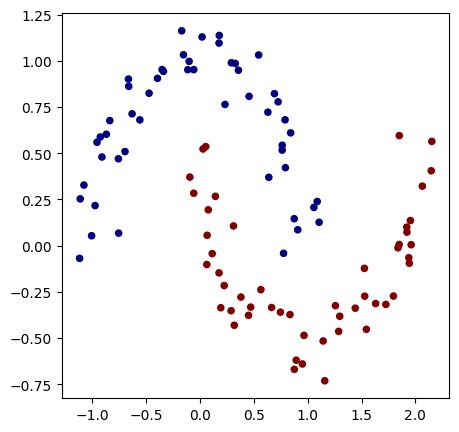

In [35]:
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples = 100, noise = 0.1)

y = 2*y - 1 # label adjustments

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], X[:, 1], c = y, s = 20, cmap = 'jet')

In [41]:
def loss(batch_size = None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]
    scores = list(map(model, inputs))

    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * 1.0 / len(losses)

    alpha = 1e-4
    reg_loss = alpha * sum([p*p for p in model.parameters()])

    total_loss = data_loss + reg_loss

    accuracy = [(scorei.data > 0) == (yi > 0) for yi, scorei in zip(yb, scores)]

    return total_loss, sum(accuracy) / len(accuracy)

In [42]:
for k in range(100):
    total_loss, acc = loss()

    learning_rate = 1 - 0.9*k/100

    model.zero_grad()
    total_loss.backward()
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f'step = {k + 1}, loss = {total_loss}, accuracy = {acc * 100}%')

step = 1, loss = Value(data = 0.23869190449240646), accuracy = 89.0%
step = 2, loss = Value(data = 0.22738719031869287), accuracy = 90.0%
step = 3, loss = Value(data = 0.21909711770080761), accuracy = 91.0%
step = 4, loss = Value(data = 0.2124366490264948), accuracy = 91.0%
step = 5, loss = Value(data = 0.20536662122918664), accuracy = 91.0%
step = 6, loss = Value(data = 0.1971995541933361), accuracy = 92.0%
step = 7, loss = Value(data = 0.18689255578086972), accuracy = 92.0%
step = 8, loss = Value(data = 0.17312422534596902), accuracy = 92.0%
step = 9, loss = Value(data = 0.15789490444642718), accuracy = 94.0%
step = 10, loss = Value(data = 0.1438994569358278), accuracy = 95.0%
step = 11, loss = Value(data = 0.1361354768327779), accuracy = 96.0%
step = 12, loss = Value(data = 0.1609749904101264), accuracy = 94.0%
step = 13, loss = Value(data = 0.13984479564195126), accuracy = 97.0%
step = 14, loss = Value(data = 0.20141339820037626), accuracy = 93.0%
step = 15, loss = Value(data = 0.1

(-1.7308755591350395, 2.0191244408649602)

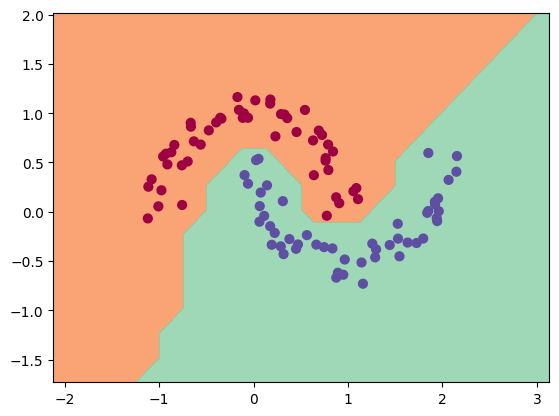

In [43]:
h = 0.25

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

Z = np.array([(scorei.data > 0) for scorei in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
